**ФИО:** Смольков Максим Дмитриевич

**Группа:** 25152

# **Множественное выравнивание последовательностей:**

**Входные данные:**

Список последовательностей и порядок их выравнивания (например, сначал первая последовательность выравнивается со второй (получаем профиль 1), потом третья с четвертой (получаем профиль 2), потом профили 1 и 2 выравниваются друг с другом)

Необходимо реализовать алгоритм множественного выравнивания (фактически модифицированный алгоритм Нидлмана-Вунша)



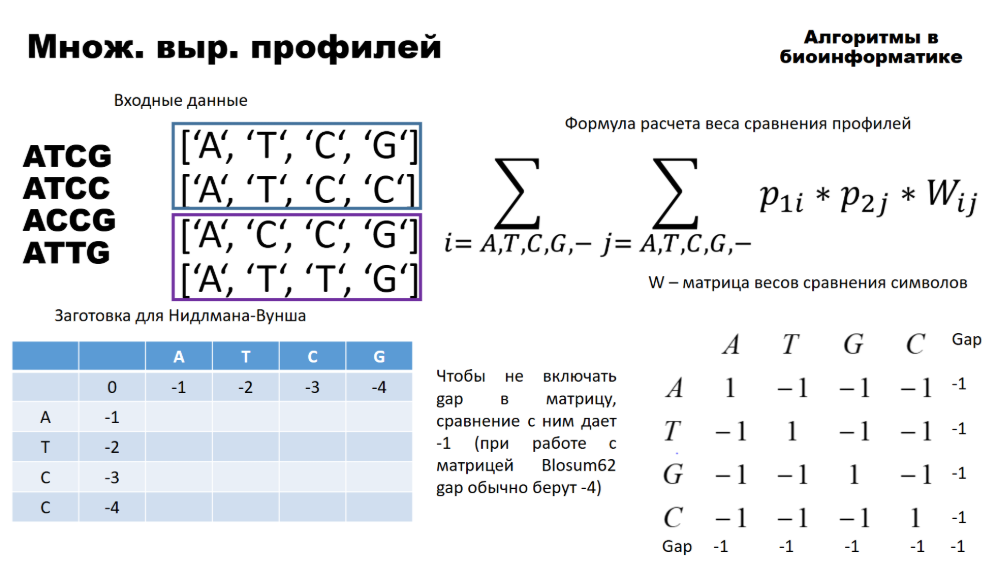

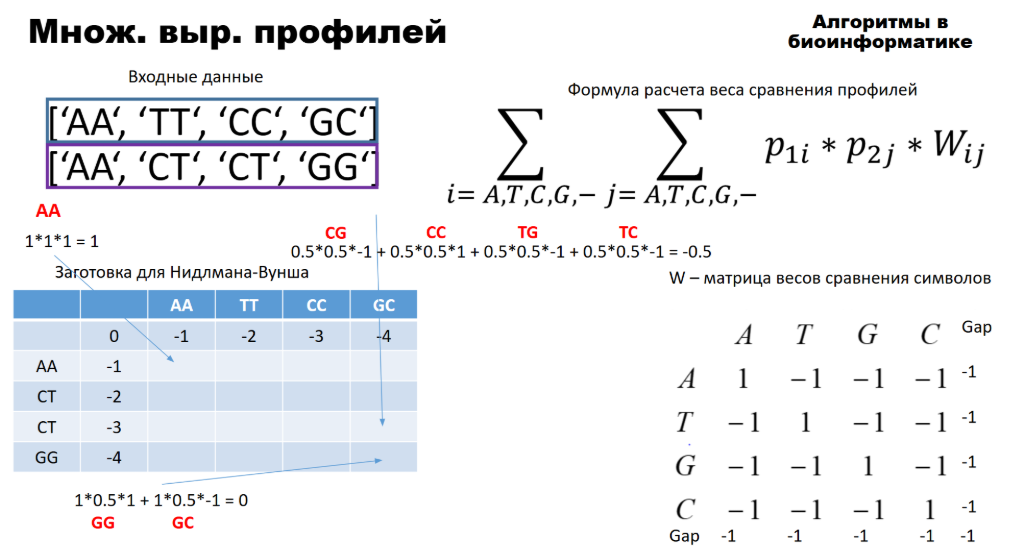

На первом этапе строится матрица, аналогичная матрице в Нидлмане-Вунше.

Первая строка и первый столбец матрицы заполняются с учетом штрафа за разрыв (гэп).

Подсчет значений в матрице производится аналогично алгоритму Нидлмана-Вунша, кроме диагонали:

* Match/mismatch рассчитывается как сумма всех возможных пар символов, взвешенных по их частоте в профилях, то есть

```
p1i + p2j * Wij, где
p1i - частота нуклеотида i в позиции первого профиля
p2j - частота нуклеотида j в позиции второго профиля
Wij - значение в матрице замен
```

Фактически в код Нидлмана-Вунша добавляется условие, что в последовательностях (профилях), которые сравниваются, может встречаться не один нуклеотид, а несколько, поэтому сравнение проводится по всем парам.

Горизонтальный и вертикальный пути высчитываются аналогично Нидлману-Вуншу: значение ячейки матрицы, из которой мы идем + штраф за гэп.

Функция должна возвращать множественное выравнивание в виде:
```
ATGCGGGT
ATGCGGGT
-TGCCGGT
-TGCCGG-
```

# **Дополнительно (то, что нужно будет для конечного конвейера)**

Можете реализовать сразу функцию удаления гэпов во множественном выравнивании и подсчет дистанции Кимуры между всему парами последовательностей.

Функция удаления гэпов простая.

Если на входе имеете множественное выравнивание вида:
```
ATGCGGGT
ATGCGGGT
-TGCCGGT
-TGCCGG-
```
Тогда функция будет удалять фактически все столбцы (все позиции) с гэпом. На выходе получите множественное выравнивание вида:
```
TGCGGG
TGCGGG
TGCCGG
TGCCGG
```
то есть удалились позиции *1* и *8*.

Функция подсчета дистанции Кимуры аналогично довольно простая.

Функция должна принимать на вход множественное выравнивание после удаления гэпов и между каждой парой последовательностей подсчитывать дистанцию Кимуры по формуле (приведена ниже).
Функция возвращает матрицу (нижне- или верхнетреугольную, аналогично матрице, которую мы получали с помощью дистанции Левенштейна) со значениями эволюционной дистанции Кимуры между всеми последовательностями.

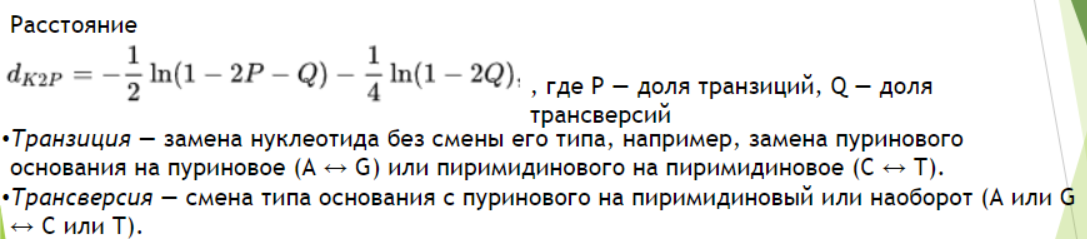

In [1]:
def profile_score(col1, col2, W):
    freq1 = {}
    freq2 = {}
    n1 = len(col1)
    n2 = len(col2)
    
    if n1 == 0 or n2 == 0:
        return 0
    
    for c in col1:
        if c not in freq1:
            freq1[c] = 0
        freq1[c] += 1
        
    for c in col2:
        if c not in freq2:
            freq2[c] = 0
        freq2[c] += 1

    score = 0
    for a, fa in freq1.items():
        for b, fb in freq2.items():
            score += (fa/n1) * (fb/n2) * W[a][b]

    return score


def needleman_wunsch_profiles(profile1, profile2, W, gap):

    n = len(profile1[0]) + 1  # длина первой последовательности
    m = len(profile2[0]) + 1  # длина второй последовательности

    # создаем матрицы
    score_matrix = [[0] * m for _ in range(n)]
    traceback = [[None] * m for _ in range(n)]

    # инициализация первой строки и столбца
    for i in range(1, n):
        score_matrix[i][0] = i * gap
        traceback[i][0] = 'up'
    for j in range(1, m):
        score_matrix[0][j] = j * gap
        traceback[0][j] = 'left'
    traceback[0][0] = '-'

    # прямой путь
    for i in range(1, n):
        for j in range(1, m):
            # столбцы профилей
            col1 = [seq[i-1] for seq in profile1]
            col2 = [seq[j-1] for seq in profile2]
            
            diag_score = score_matrix[i-1][j-1] + profile_score(col1, col2, W)
            up_score = score_matrix[i-1][j] + gap
            left_score = score_matrix[i][j-1] + gap

            max_score = max(diag_score, up_score, left_score)
            score_matrix[i][j] = max_score

            if diag_score == max_score:
                traceback[i][j] = 'diag'
            elif up_score == max_score:
                traceback[i][j] = 'up'
            else:
                traceback[i][j] = 'left'

    # обратный путь: строим выравненный профиль
    align1 = ['' for _ in profile1]
    align2 = ['' for _ in profile2]
    i, j = n - 1, m - 1

    while i>0 or j>0:
        move = traceback[i][j]
        if move == 'diag':
            for idx, seq in enumerate(profile1):
                align1[idx] += seq[i-1]
            for idx, seq in enumerate(profile2):
                align2[idx] += seq[j-1]
            i -= 1
            j -= 1
        elif move == 'up':
            for idx, seq in enumerate(profile1):
                align1[idx] += seq[i-1]
            for idx in range(len(profile2)):
                align2[idx] += '-'
            i -= 1
        elif move == 'left':
            for idx in range(len(profile1)):
                align1[idx] += '-'
            for idx, seq in enumerate(profile2):
                align2[idx] += seq[j-1]
            j -= 1

    # переворачиваем строки, потому что строились с конца
    align1 = [''.join(reversed(s)) for s in align1]
    align2 = [''.join(reversed(s)) for s in align2]

    # объединяем два профиля
    new_profile = align1 + align2
    return score_matrix, new_profile


def multiple_sequence_alignment(sequences, pairs_order, W, gap=-1):
    profiles = [[s] for s in sequences]

    for i, j in pairs_order:
        prof1 = profiles[i]
        prof2 = profiles[j]

        # выравниваем профили
        _, new_profile = needleman_wunsch_profiles(prof1, prof2, W, gap)

        # заменяем первый профиль на объединенный, удаляем второй
        profiles[i] = new_profile
        profiles[j] = None

    profiles = [p for p in profiles if p is not None]

    # в итоге остается один объединённый профиль
    return profiles[0]


In [ ]:
# Пример вызова функции

seqs = [
    "ATGCGGGT",
    "ATGCGGGT",
    "TGCCGGT",
    "TGCCGG"
]

pairs_order = [(0, 1), (2, 3), (0, 2)]

W = {
    'A':{'A':1,'C':-1,'G':-1,'T':-1,'-':-1},
    'C':{'A':-1,'C':1,'G':-1,'T':-1,'-':-1},
    'G':{'A':-1,'C':-1,'G':1,'T':-1,'-':-1},
    'T':{'A':-1,'C':-1,'G':-1,'T':1,'-':-1},
    '-':{'A':-1,'C':-1,'G':-1,'T':-1,'-':-1}
}

gap = -1

msa = multiple_sequence_alignment(seqs, pairs_order, W, gap)

for row in msa:
    print(row)

ATGCGGGT
ATGCGGGT
-TGCCGGT
-TGCCGG-


In [ ]:
from typing import List, Tuple
import math

def remove_gapped_columns(aligned_sequences: List[str]) -> List[str]:
    """
    Удаляет все колонки, где есть хотя бы один '-'
    Возвращает очищенные последовательности (без гэпов вообще)
    """
    if not aligned_sequences:
        return []
    
    length = len(aligned_sequences[0])
    n = len(aligned_sequences)
    
    cleaned = [""] * n
    
    for col in range(length):
        column = [aligned_sequences[i][col] for i in range(n)]
        if '-' not in column:  # только если ни одного гэпа
            for i in range(n):
                cleaned[i] += column[i]
    
    return cleaned

In [2]:
def k2p_distance(seq1: str, seq2: str) -> float:
    """
    Вычисляет расстояние Кимуры 2-параметра между двумя последовательностями.
    
    Args:
        seq1: Первая последовательность
        seq2: Вторая последовательность
        
    Returns:
        Расстояние Кимуры 2-параметра
    """
    if len(seq1) != len(seq2):
        raise ValueError("Последовательности должны иметь одинаковую длину")
    
    # Определяем пурины и пиримидины
    purines = {'A', 'G'}
    pyrimidines = {'C', 'T', 'U'}  # U для РНК
    
    # Счетчики
    transitions = 0  # транзиции: A↔G, C↔T
    transversions = 0  # трансверсии: A/G ↔ C/T
    total = 0  # общее количество сравненных позиций
    
    for n1, n2 in zip(seq1, seq2):
        # Пропускаем гэпы и неопределенные нуклеотиды
        if n1 == '-' or n2 == '-' or n1 == 'N' or n2 == 'N':
            continue
        
        if n1 == n2:
            total += 1
            continue
        
        total += 1
        
        # Определяем тип замены
        if (n1 in purines and n2 in purines) or (n1 in pyrimidines and n2 in pyrimidines):
            # Транзиция (внутри одного типа)
            transitions += 1
        else:
            # Трансверсия (между типами)
            transversions += 1
    
    if total == 0:
        return 0.0
    
    # Вычисляем доли
    P = transitions / total
    Q = transversions / total
    
    # Формула Кимуры 2-параметра
    # d = -1/2 * ln(1 - 2P - Q) - 1/4 * ln(1 - 2Q)
    
    # Проверяем, чтобы аргументы логарифмов были положительными
    term1 = 1 - 2*P - Q
    term2 = 1 - 2*Q
    
    if term1 <= 0 or term2 <= 0:
        # Если аргументы неположительные, используем Jukes-Cantor как запасной вариант
        # или возвращаем большое расстояние
        diff_sites = transitions + transversions
        p = diff_sites / total if total > 0 else 0
        if p >= 0.75:
            return float('inf')
        return -0.75 * math.log(1 - (4/3) * p)
    
    d = -0.5 * math.log(term1) - 0.25 * math.log(term2)
    
    return d